This notebook is to find the statistics of the EUV wave in SUVI and LASCO C2/C3

In [180]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import sunpy.sun.constants as const
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

data_dir = '/home/mnedal/data'

In [123]:
suvi_filenames = sorted(glob.glob(f'{data_dir}/jplots/suvi/clicking/*.csv'))
c2_filenames   = sorted(glob.glob(f'{data_dir}/jplots/lasco_C2/clicking/*.csv'))
c3_filenames   = sorted(glob.glob(f'{data_dir}/jplots/lasco_C3/clicking/*.csv'))

print(len(suvi_filenames), len(c2_filenames), len(c3_filenames))

13 16 13


In [124]:
slits = myfuncs.generate_centered_list(160, 2, 6)
print(slits, '--> Length:', len(slits))

[148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172] --> Length: 13


In [125]:
# Filter filenames based on the slit number
suvi_filenames = [
    filename for filename in suvi_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

c2_filenames = [
    filename for filename in c2_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

c3_filenames = [
    filename for filename in c3_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

print(len(suvi_filenames), len(c2_filenames), len(c3_filenames))

# get the radius of the Sun in km
sun_radius_km = const.radius.to('km').value

13 13 13


In [206]:
all_speeds_suvi  = []
all_accels_suvi  = []
all_times_suvi   = []
all_dists_suvi   = []
for file in suvi_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_suvi.append(df['speed_km_s'].values)
    all_accels_suvi.append(df['accel_m_s2'].values)
    all_times_suvi.append(df['time'].values)
    all_dists_suvi.append(df['distance_km'].values/sun_radius_km)
    # print(f"Max: {np.nanmax(df['distance_km'].values/sun_radius_km):.2f} Rs")
    # print(f"Min: {np.nanmin(df['distance_km'].values/sun_radius_km):.2f} Rs\n")

Start height: 1.17 Rs
End height:  1.92 Rs

Start time: 2024-05-14 17:12:35
End time:  2024-05-14 17:37:02


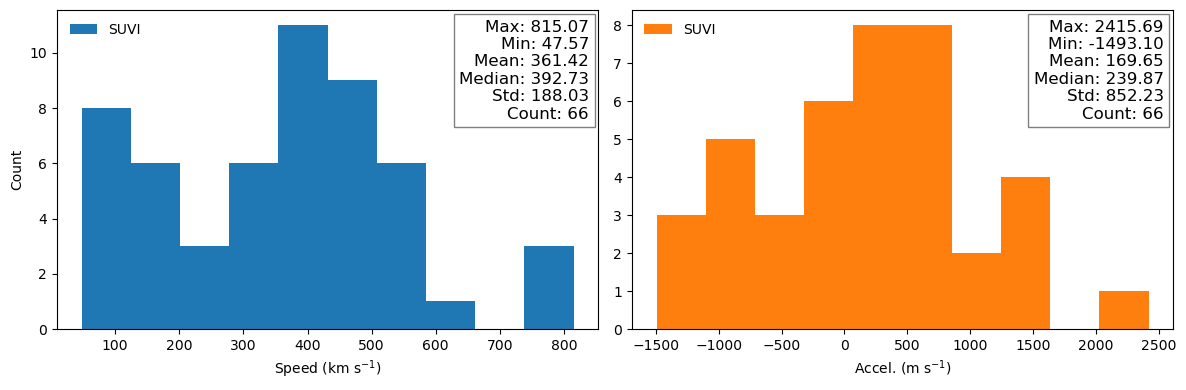

In [209]:
# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_suvi)
combined_array_a = np.concatenate(all_accels_suvi)
combined_array_t = np.concatenate(all_times_suvi)
combined_array_d = np.concatenate(all_dists_suvi)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='SUVI',
         # edgecolor='black'
        )
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.983, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='SUVI')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.983, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_suvi.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [210]:
all_speeds_c2 = []
all_accels_c2 = []
all_times_c2  = []
all_dists_c2  = []
for file in c2_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_c2.append(df['speed_km_s'].values)
    all_accels_c2.append(df['accel_m_s2'].values)
    all_times_c2.append(df['time'].values)
    all_dists_c2.append(df['distance_km'].values/sun_radius_km)

Start height: 2.78 Rs
End height:  7.08 Rs

Start time: 2024-05-14 17:47:53
End time:  2024-05-14 18:24:36


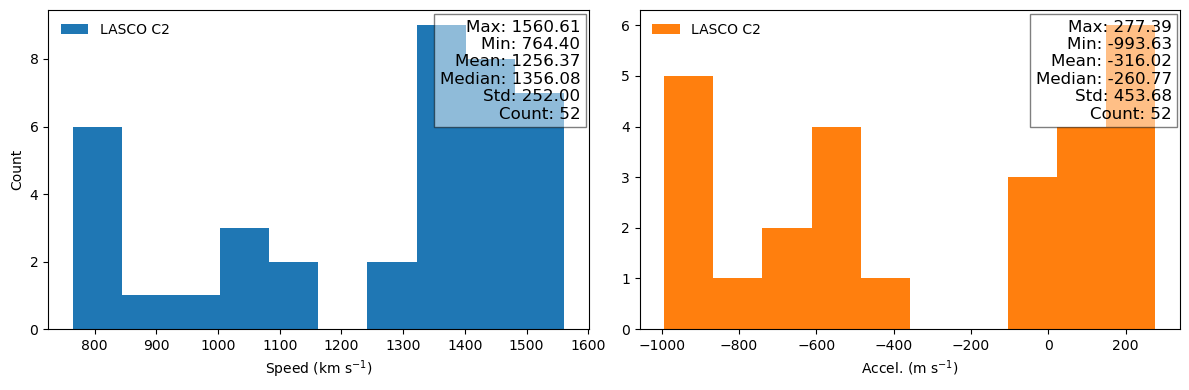

In [211]:
# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_c2)
combined_array_a = np.concatenate(all_accels_c2)
combined_array_t = np.concatenate(all_times_c2)
combined_array_d = np.concatenate(all_dists_c2)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='LASCO C2',
         # edgecolor='black'
        )
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='LASCO C2')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_c2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [212]:
all_speeds_c3 = []
all_accels_c3 = []
all_times_c3  = []
all_dists_c3  = []
for file in c3_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_c3.append(df['speed_km_s'].values)
    all_accels_c3.append(df['accel_m_s2'].values)
    all_times_c3.append(df['time'].values)
    all_dists_c3.append(df['distance_km'].values/sun_radius_km)

Start height: 4.00 Rs
End height:  30.55 Rs

Start time: 2024-05-14 17:53:52
End time:  2024-05-14 23:01:39


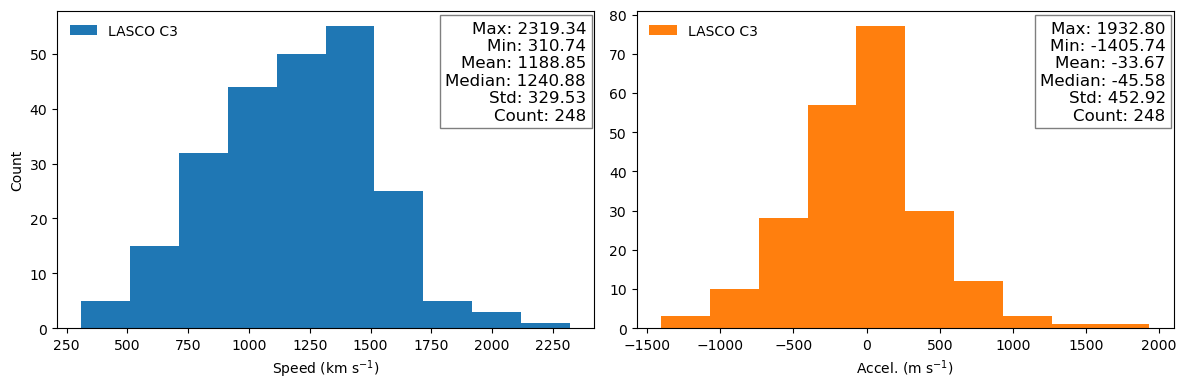

In [213]:
# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_c3)
combined_array_a = np.concatenate(all_accels_c3)
combined_array_t = np.concatenate(all_times_c3)
combined_array_d = np.concatenate(all_dists_c3)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='LASCO C3')
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.985, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='LASCO C3')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_c3.pdf', format='pdf', bbox_inches='tight')
plt.show()